In [96]:
import pandas as pd

df = pd.read_csv("data/tweetdfsiliconvb275t.csv", encoding="latin1", low_memory=False)



In [89]:

import pandas as pd
import re
import spacy
import nltk
import contextlib
import os
import sys
from nltk.corpus import stopwords

# Load first 1000 rows
df = df.head(10000)
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"])

#Suppress nltk output 
with open(os.devnull, "w") as fnull:
    with contextlib.redirect_stdout(fnull), contextlib.redirect_stderr(fnull):
        nltk.download("stopwords", quiet=True)

# Text preprocessing setup
stop_words = set(stopwords.words("english"))
nlp = spacy.load("en_core_web_sm")

def preprocess(text):
    text = re.sub(r"http\S+", "http", str(text))
    text = re.sub(r"@\w+", "@user", text)
    text = re.sub(r"[^A-Za-z\s]", "", text.lower())
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.lemma_ not in stop_words and not token.is_space]
    return " ".join(tokens)

df["clean_text"] = df["tweet"].astype(str).apply(preprocess)


In [90]:
from transformers import pipeline, logging

logging.set_verbosity_error()

sentiment_model = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment",
    device=0
)

emotion_model = pipeline(
    "text-classification",
    model="cardiffnlp/twitter-roberta-base-emotion",
    top_k=None,
    device=0
)


# Apply models
df["sentiment"] = df["clean_text"].apply(
    lambda x: sentiment_model(x)[0]["label"]
)

df["emotion"] = df["clean_text"].apply(
    lambda x: max(emotion_model(x)[0], key=lambda e: e["score"])["label"]
)


In [91]:
keywords = [
    "withdraw", "bank", "collapse", "fdic", "run", "money", "risk", "panic",
    "queue", "safe", "account", "deposit", "guarantee", "insured"
]

def keyword_flags(text):
    words = set(text.split())
    return {kw: int(kw in words) for kw in keywords}

kw_df = df["clean_text"].apply(keyword_flags).apply(pd.Series)
df = pd.concat([df, kw_df], axis=1)

In [92]:
import pandas as pd

# Ensure 'date' is datetime
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Fix deprecation warning
df["hour"] = df["date"].dt.floor("h")

# Tweet volume per hour
tweet_volume = df["hour"].value_counts().sort_index()

# Sentiment per hour
sentiment_by_hour = (
    df.groupby("hour")["sentiment"]
    .value_counts()
    .unstack()
    .fillna(0)
    .sort_index()
)

# Emotion per hour
emotion_by_hour = (
    df.groupby("hour")["emotion"]
    .value_counts()
    .unstack()
    .fillna(0)
    .sort_index()
)

# Keywords per hour 
if 'keywords' in globals():
    keyword_trends = df.groupby("hour")[keywords].sum()


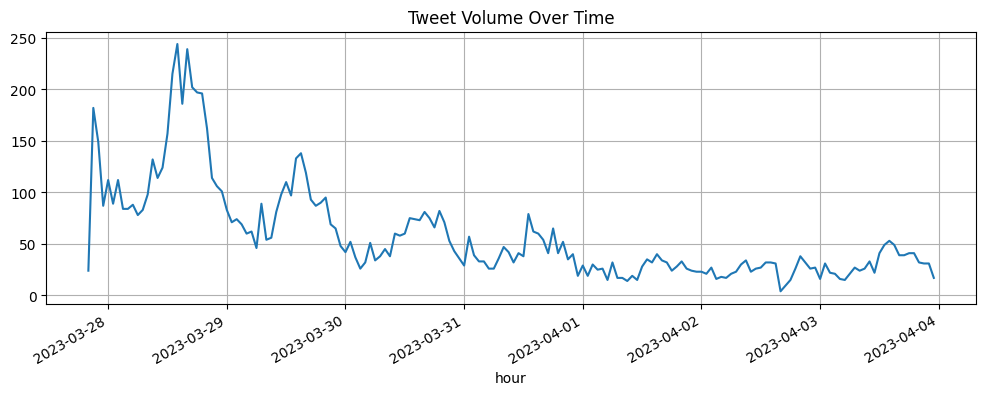

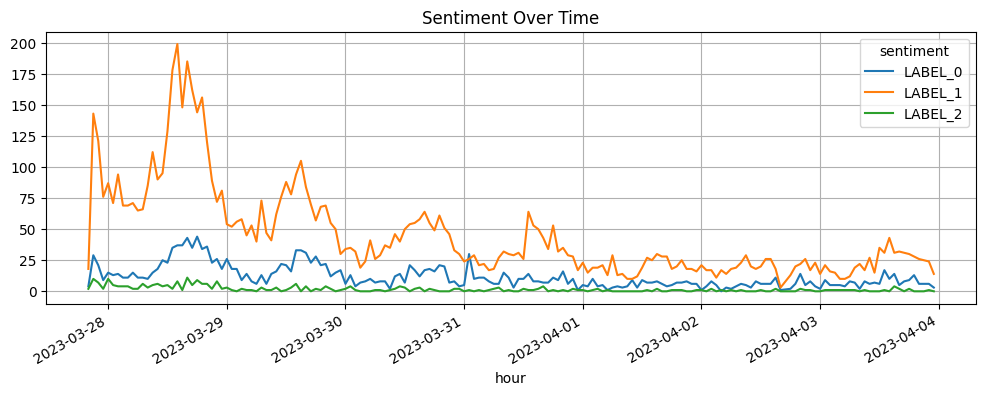

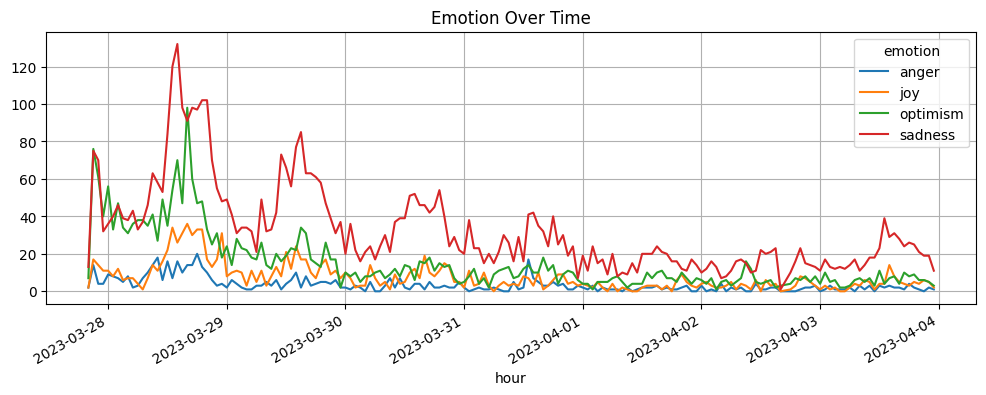

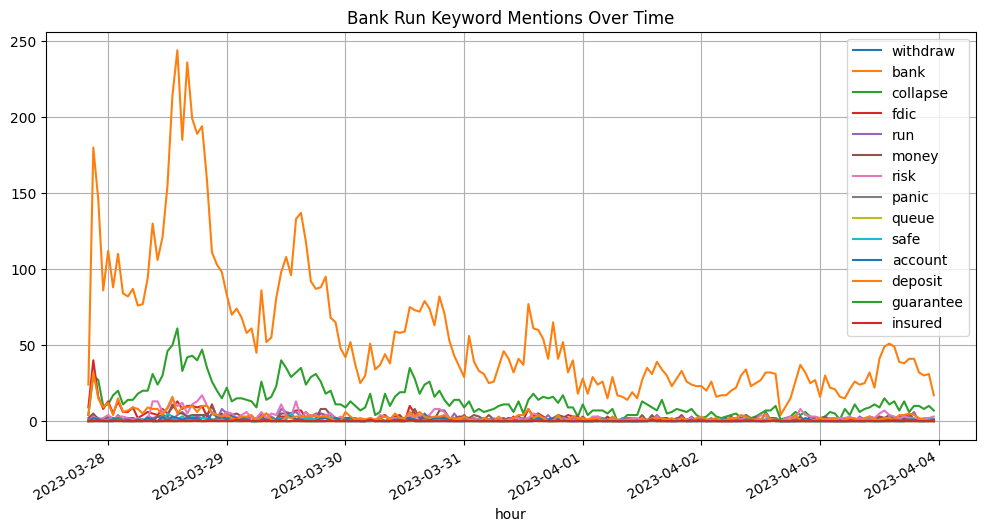

In [93]:
import matplotlib.pyplot as plt

# Tweet volume
tweet_volume.plot(figsize=(12, 4), title="Tweet Volume Over Time", grid=True)
plt.show()

# Sentiment
sentiment_by_hour.plot(figsize=(12, 4), title="Sentiment Over Time", grid=True)
plt.show()

# Emotion
emotion_by_hour.plot(figsize=(12, 4), title="Emotion Over Time", grid=True)
plt.show()

# Keywords
keyword_trends.plot(figsize=(12, 6), title="Bank Run Keyword Mentions Over Time", grid=True)
plt.show()


In [94]:

import numpy as np

# Define event date
event_date = pd.to_datetime("2023-03-09").tz_localize("UTC")


# Filter time windows
pre_window = df[df["date"] < event_date]
post_window = df[df["date"] >= event_date]

# Get sentiment proportions
sentiment_dist_pre = pre_window["sentiment"].value_counts(normalize=True)
sentiment_dist_post = post_window["sentiment"].value_counts(normalize=True)

# Get emotion proportions
emotion_dist_pre = pre_window["emotion"].value_counts(normalize=True)
emotion_dist_post = post_window["emotion"].value_counts(normalize=True)

# Combine into DataFrames for easy comparison
sentiment_comparison = pd.DataFrame({
    "pre": sentiment_dist_pre,
    "post": sentiment_dist_post
}).fillna(0)

emotion_comparison = pd.DataFrame({
    "pre": emotion_dist_pre,
    "post": emotion_dist_post
}).fillna(0)

print("Sentiment Comparison:")
print(sentiment_comparison)

print("\nEmotion Comparison:")
print(emotion_comparison)


Sentiment Comparison:
           pre      post
sentiment               
LABEL_0    0.0  0.198940
LABEL_1    0.0  0.773155
LABEL_2    0.0  0.027906

Emotion Comparison:
          pre      post
emotion                
anger     0.0  0.058812
joy       0.0  0.127926
optimism  0.0  0.258352
sadness   0.0  0.554911


In [95]:
from scipy.stats import chi2_contingency

# Sentiment
sentiment_table = pd.crosstab(
    df["sentiment"], 
    df["date"] >= event_date  
)

chi2_sent, p_sent, _, _ = chi2_contingency(sentiment_table)

# Emotion
emotion_table = pd.crosstab(
    df["emotion"], 
    df["date"] >= event_date
)

chi2_emotion, p_emotion, _, _ = chi2_contingency(emotion_table)

print(f"\nChi-squared test for Sentiment: p-value = {p_sent:.4f}")
print(f"Chi-squared test for Emotion: p-value = {p_emotion:.4f}")



Chi-squared test for Sentiment: p-value = 1.0000
Chi-squared test for Emotion: p-value = 1.0000
